In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import UMAP_neural_network

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import fashion_mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

print(len(X_train), len(X_valid))

50000 10000


### define network

In [7]:
dims = (28,28,1)
n_components = 2

In [8]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dense(n_components, activation=None, name='z'))

### Create model and train

In [9]:
embedder = UMAP_neural_network(
    training_epochs=5,
    max_sample_repeats_per_epoch=10,
    train_classifier=True,
    valid_X = X_valid,
    valid_Y = Y_valid,
    verbose=True,
    dims=dims,
    n_components=n_components,
    encoder=encoder,
    target_weight=1.0,
)

In [10]:
z = embedder.fit_transform(X_train, y=Y_train)

Construct fuzzy simplicial set
Sun May 31 18:34:32 2020 Finding Nearest Neighbors
Sun May 31 18:34:32 2020 Building RP forest with 16 trees
Sun May 31 18:34:34 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Sun May 31 18:34:47 2020 Finished Nearest Neighbor Search
Sun May 31 18:34:50 2020 Embedding with TensorFlow


Sun May 31 18:39:26 2020 Finished embedding


### look at network architecture

In [11]:
embedder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [12]:
embedder.classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
predictions (Dense)          (None, 10)                1010      
Total params: 34,110
Trainable params: 34,110
Non-trainable params: 0
_________________________________________________________________


### Plot model output

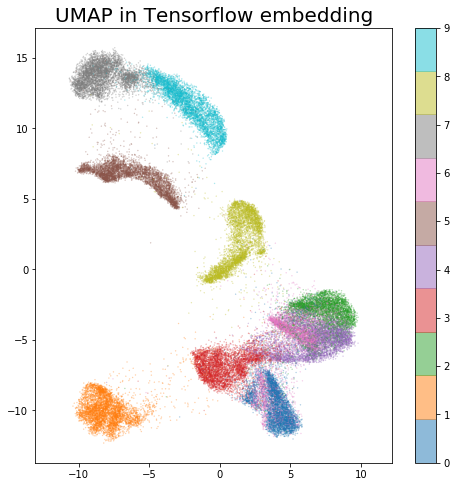

In [13]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### embed test data

In [14]:
z_test = embedder.transform(X_test)

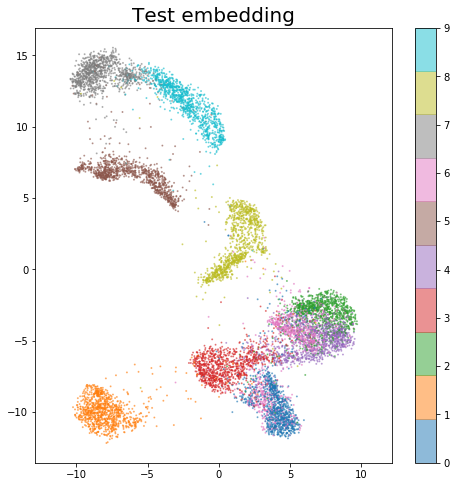

In [15]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_test[:, 0],
    z_test[:, 1],
    c=Y_test.astype(int)[:len(z)],
    cmap="tab10",
    s=1.0,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Test embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [16]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [17]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'classif_loss', 'classif_acc']
['classif_loss', 'classif_acc']


,wall_time,step,val,group,variable
0,1.590975e+09,1,5.011419,train,umap_loss
1,1.590975e+09,2,3.132861,train,umap_loss
2,1.590975e+09,3,2.243736,train,umap_loss


In [18]:
loss_df.variable.unique()

array(['umap_loss', 'classif_loss', 'classif_acc'], dtype=object)

Text(0.5, 1.0, 'Classifier Accuracy')

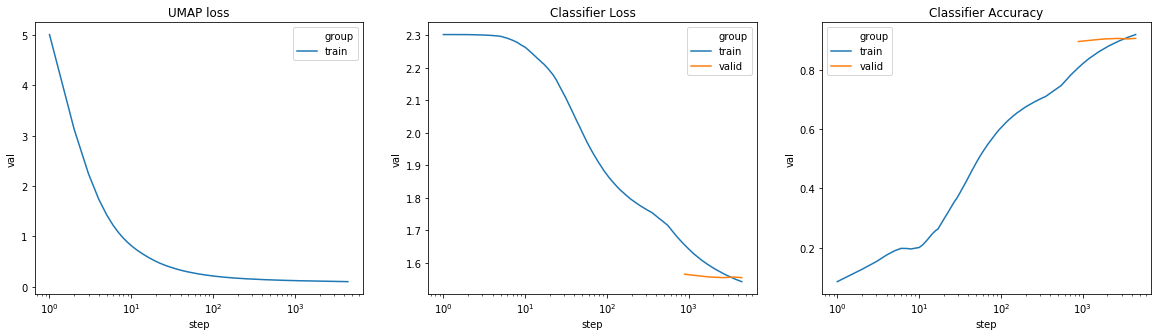

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('Classifier Loss')

ax = axs[2]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_acc'], ax = ax)
ax.set_xscale('log')
ax.set_title('Classifier Accuracy')

### plot output of last layer before desciminator and encoder diverge

In [20]:
X = X_test

In [21]:
# get output of last layer
n_batches = np.ceil(len(X) / embedder.batch_size).astype(int)
if len(embedder.dims) > 1:
    X = np.reshape(X, [len(X)] + list(embedder.dims))

projections = []
for batch in np.arange(n_batches):
    projections.append(
        embedder.encoder_base(
            X[(batch * embedder.batch_size) : ((batch + 1) * embedder.batch_size)]
        ).numpy()
    )
projections = np.vstack(projections)
np.shape(projections)

(10000, 128)

In [22]:
import umap

In [23]:
proj_embed = umap.UMAP()
proj_z = proj_embed.fit_transform(X=projections)

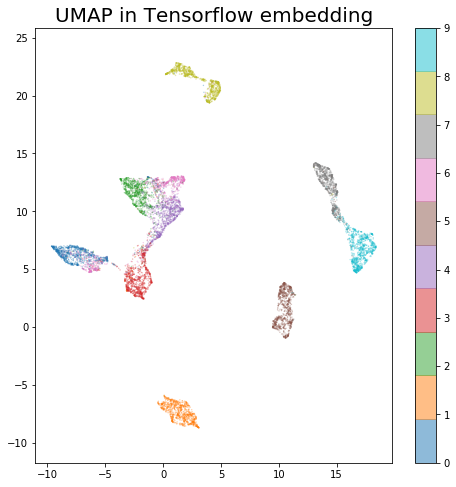

In [24]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    proj_z[:, 0],
    proj_z[:, 1],
    c=Y_test.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### get accuracy of classifier on the test data

In [25]:
X = X_test
Y = Y_test

In [26]:
# get output of last layer
n_batches = np.ceil(len(X) / embedder.batch_size).astype(int)
if len(embedder.dims) > 1:
    X = np.reshape(X, [len(X)] + list(embedder.dims))

predictions = []
for batch in np.arange(n_batches):
    predictions.append(
        embedder.classifier(embedder.encoder_base(
            X[(batch * embedder.batch_size) : ((batch + 1) * embedder.batch_size)]
        )).numpy()
    )
predictions = np.vstack(predictions)
np.shape(predictions)
acc = tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(tf.Variable(Y), predictions))
top_1 = np.argmax(predictions, axis=1)

In [27]:
print(acc)

tf.Tensor(0.906, shape=(), dtype=float32)
